In [1]:
"""
Atividade para trabalhar o pré-processamento dos dados.
Criação de modelo preditivo para diabetes e envio para verificação de peformance
no servidor.
@author: Aydano Machado <aydano.machado@gmail.com>
"""

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import requests

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer

In [50]:
print('\n - Lendo o arquivo com o dataset sobre diabetes')
data = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/01_Preprocessing/diabetes_dataset.csv')

data


 - Lendo o arquivo com o dataset sobre diabetes


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
4,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
567,9,89.0,62.0,NaN,NaN,22.5,0.142,33,0
568,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
569,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
570,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


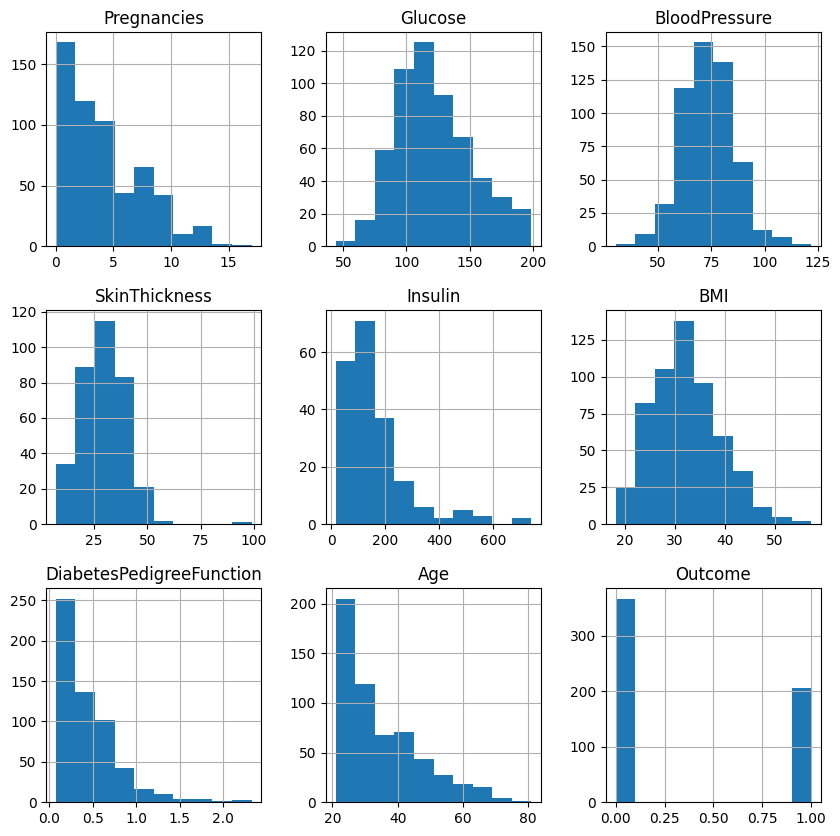

In [34]:
data.hist(figsize = (10, 10))
plt.show()

In [63]:
# Checando colunas com dados faltantes
for column in data.columns:
    print(f'###  {column}  ###')

    print(f"NaN: {data[column].isna().sum()}")
    print('')

###  Pregnancies  ###
NaN: 0

###  Glucose  ###
NaN: 5

###  BloodPressure  ###
NaN: 35

###  SkinThickness  ###
NaN: 227

###  Insulin  ###
NaN: 374

###  BMI  ###
NaN: 11

###  DiabetesPedigreeFunction  ###
NaN: 0

###  Age  ###
NaN: 0

###  Outcome  ###
NaN: 0



In [56]:
# Criando X and y par ao algorítmo de aprendizagem de máquina.\
print(' - Criando X e y para o algoritmo de aprendizagem a partir do arquivo diabetes_dataset')

def fill_nan(df):
    # Preenchimento com a mediana
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

    #df = df[feature_cols]
    idf = pd.DataFrame(imputer.fit_transform(df))
    idf.columns = df.columns
    idf.index = df.index

    return idf


def fill_nan_by_class(df):
    # Separar entre saudáveis e diabéticos para adicionar o valores faltantes
    df_healthy = df[df['Outcome']==0].copy()
    df_sick = df[df['Outcome']==1].copy()

    # Preencher dados faltantes usando a mediana da classe
    for column in df_healthy.columns[:-1]:
        df_healthy[column].fillna(df_healthy[column].median(), inplace=True)

    for column in df_sick.columns[:-1]:
        df_sick[column].fillna(df_sick[column].median(), inplace=True)

    df_all = pd.concat([df_healthy, df_sick])

    return df_all


def remove_nan(df):
    cols_to_drop_na = ['Pregnancies', 'Glucose', 'BloodPressure', 
                'BMI', 'DiabetesPedigreeFunction', 'Age'] # 'SkinThickness', 'Insulin'

    df = df.dropna(subset=cols_to_drop_na)

    return df


# Caso queira modificar as colunas consideradas basta algera o array a seguir.
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age'] #, 'SkinThickness', 'Insulin']
cols = [*feature_cols, 'Outcome']

new_data = data[cols]
#new_data = remove_nan(new_data)
#new_data = fill_nan(new_data)
new_data = fill_nan_by_class(new_data)


X = new_data[feature_cols]
y = new_data['Outcome']

 - Criando X e y para o algoritmo de aprendizagem a partir do arquivo diabetes_dataset


In [57]:
X

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
1,1,85.0,66.0,26.6,0.351,31
4,5,116.0,74.0,25.6,0.201,30
5,10,115.0,72.0,35.3,0.134,29
8,4,110.0,92.0,37.6,0.191,30
10,10,139.0,80.0,27.1,1.441,57
...,...,...,...,...,...,...
560,8,154.0,78.0,32.4,0.443,45
562,0,123.0,72.0,36.3,0.258,52
564,6,190.0,92.0,35.5,0.278,66
566,9,170.0,74.0,44.0,0.403,43


In [58]:
from sklearn.preprocessing import PowerTransformer

# Normalizando os dados

X_temp = X.copy()
X_temp['Class'] = -1

normalize = PowerTransformer().fit(X)

X_norm = pd.DataFrame(normalize.transform(X), columns = X.columns)
X_norm = X_norm.round(2)

X_norm

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,-0.91,-1.31,-0.59,-0.84,-0.09,0.03
1,0.49,-0.09,0.09,-1.02,-0.98,-0.08
2,1.45,-0.12,-0.08,0.52,-1.52,-0.20
3,0.23,-0.30,1.56,0.84,-1.06,-0.08
4,1.45,0.65,0.58,-0.75,1.94,1.56
...,...,...,...,...,...,...
567,1.11,1.08,0.42,0.10,0.31,1.06
568,-1.60,0.15,-0.08,0.66,-0.60,1.38
569,0.72,1.99,1.56,0.55,-0.48,1.82
570,1.29,1.50,0.09,1.62,0.15,0.95


In [59]:
# Normalizando os dados de teste
data_app = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/01_Preprocessing/diabetes_app.csv')

data_app = data_app[feature_cols]

data_app_norm = pd.DataFrame(normalize.transform(data_app), columns = data_app.columns)
data_app_norm = data_app_norm.round(2)

data_app_norm 

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,-0.07,0.34,-0.76,-0.88,-0.85,-0.32
1,-0.07,2.01,-0.42,-0.13,-0.36,0.32
2,2.12,0.56,-0.25,0.77,-1.36,0.95
3,-0.91,-0.34,-1.10,-1.06,1.48,-1.49
4,1.11,1.00,0.42,1.50,0.57,0.48
...,...,...,...,...,...,...
191,-0.07,1.75,-0.76,0.34,-0.52,-0.60
192,-0.07,-0.72,-1.62,-1.02,-1.35,-0.91
193,1.11,1.65,1.40,0.30,0.40,1.59
194,-1.60,-1.36,0.75,0.91,-0.76,-1.09


In [105]:
# Estratégia pra usar PCA
# from sklearn.decomposition import PCA # Make an instance of the Model

# pca = PCA(.95) # retém 95% da variância do dataset

# pca.fit(X_norm)

# X_norm = pca.transform(X_norm)
# data_app = pca.transform(data_app)

In [60]:
# Ciando o modelo preditivo para a base trabalhada
print(' - Criando modelo preditivo')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_norm, y)

 - Criando modelo preditivo


KNeighborsClassifier(n_neighbors=3)

In [61]:
#realizando previsões com o arquivo de
print(' - Aplicando modelo e enviando para o servidor')
#data_app = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/01_Preprocessing/diabetes_app.csv')
#data_app = data_app[feature_cols]

y_pred = neigh.predict(data_app_norm)

# Enviando previsões realizadas com o modelo para o servidor
URL = "https://aydanomachado.com/mlclass/01_Preprocessing.php"

#TODO Substituir pela sua chave aqui
DEV_KEY = "720pster"

# json para ser enviado para o servidor
data_json = {'dev_key':DEV_KEY,
        'predictions':pd.Series(y_pred).to_json(orient='values')}

 - Aplicando modelo e enviando para o servidor


In [62]:
# Enviando requisição e salvando o objeto resposta
r = requests.post(url = URL, data = data_json)

# Extraindo e imprimindo o texto da resposta
pastebin_url = r.text
print(" - Resposta do servidor:\n", r.text, "\n")

 - Resposta do servidor:
 {"error":{"code":102,"message":"Espere ao menos 10 minutos entre dois envios, tempo restante 00 dias 00 horas 12 minutos 40 segundos"}} 

